# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# heat_data = pd.read_excel('MCC 2024 ALL CALIBRATED Time Matched.xlsx', sheet_name='Sheet1')
# heat_data = pd.read_csv('six_sheep_may_data.csv', sep='\t')
heat_data = pd.read_excel('First six CALIBRATED.xlsx', sheet_name='Sheet1')
heat_data.columns = [col.replace(" ", '') for col in heat_data.columns]
heat_data['DT'] = pd.to_datetime(heat_data['DT'])
heat_data.head(10)

,DT,row,M0177,M1215,M1221,M1241,M1275,M1278
0,2024-04-24 23:59:59.990,36662,39.556083,39.815960,39.447140,39.873958,40.338244,39.815049
1,2024-04-25 00:04:59.990,36663,39.610716,39.808166,39.493920,39.686911,40.353814,39.846257
2,2024-04-25 00:09:59.990,36664,39.704372,39.800372,38.402370,39.772641,40.338244,39.846257
3,2024-04-25 00:14:59.990,36665,39.759005,39.784784,38.745429,39.889545,40.182546,39.861860
4,2024-04-25 00:19:59.990,36666,39.782419,39.800372,39.049504,39.905132,40.151407,39.916474
5,2024-04-25 00:24:59.990,36667,39.743395,39.776990,39.127471,39.928513,40.166977,39.939879
6,2024-04-25 00:29:59.990,36668,39.680958,39.792578,39.174252,39.920720,40.260395,39.971087
7,2024-04-25 00:34:59.990,36669,39.719981,39.784784,39.205439,39.881752,40.283750,39.986691
8,2024-04-25 00:39:59.990,36670,39.782419,39.800372,39.228830,39.889545,40.275965,39.955483
9,2024-04-25 00:44:59.990,36671,39.774614,39.808166,39.299001,39.920720,40.338244,39.893068


In [3]:
pd.read_excel?

In [4]:
# heat_data

In [5]:
# heat_data.to_csv('MCC_2024_All_Calibrated_Time_Match.csv', index=False)
# heat_data['DT'] = pd.to_datetime(heat_data['DT'])

Text(0.5, 1.0, 'Variation of Rumen Temperature of Logger M0177')

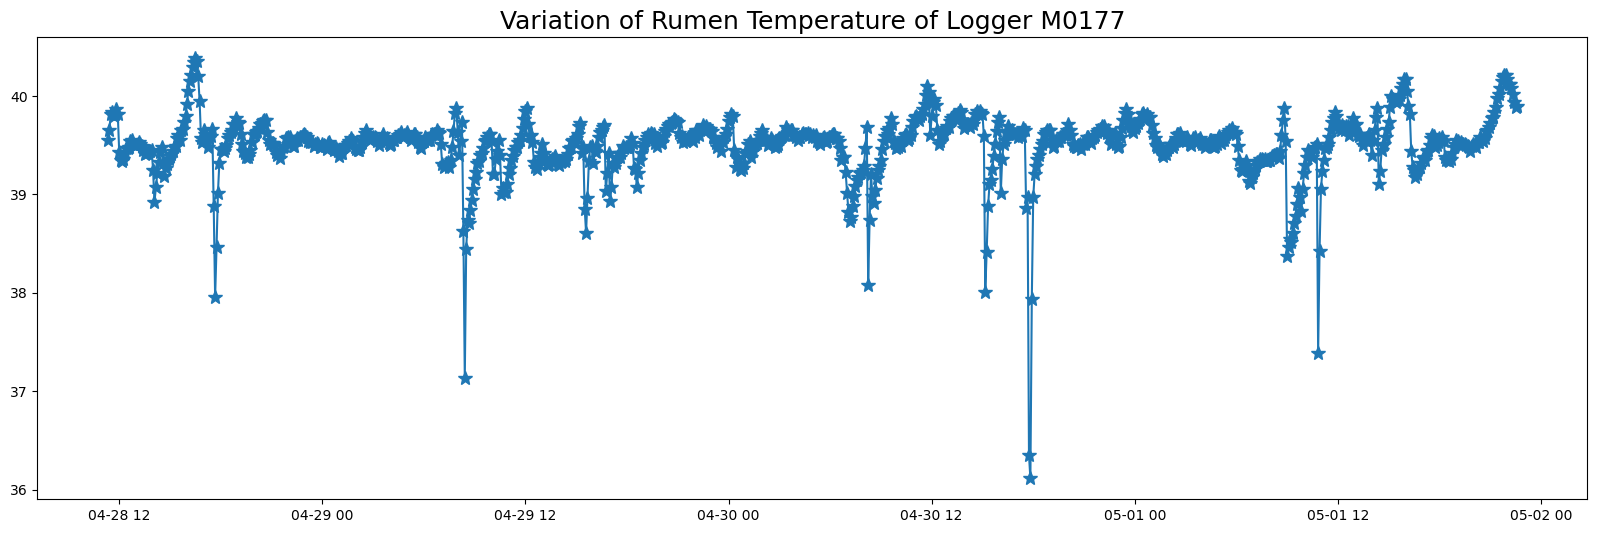

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))  # 设置图形的大小
plt.plot(heat_data['DT'][1000:2000], heat_data['M0177'][1000:2000], '-o', marker='*', markersize=10, label='Temperature')  # '-o'表示连线图，'*'表示星号标记
plt.title("Variation of Rumen Temperature of Logger M0177", fontsize=18)


In [7]:
# heat_data = heat_data[(heat_data['DT'] > '2023-02-14')]
heat_data = heat_data.reset_index(drop=True)

# Drink behaviour detection and interpolating makeup

In [8]:
def remove_outliers_interpolate_drink(data, col_name, temp_thresh=-0.5):

#     data['DT'] = pd.to_datetime(data['DT'])
    data = data.reset_index()
#     print(data.head())
    # Filter out abnormal data, keeping records where temperature is >= 30 degrees
    filtered_data = data[data[col_name] >= 30]


    # Calculate temperature changes to help identify drinking events
    filtered_data['Temp_Change'] = filtered_data[col_name].diff()

    # Define a significant temperature drop (>1 degree within 5 to 10 minutes)
    # This accounts for consecutive readings, considering the data sampling rate (every 5 minutes)
    filtered_data['Temp_Change_2'] = filtered_data[col_name].diff(2)  # Change over 10 minutes
    filtered_data['Significant_Drop'] = ((filtered_data['Temp_Change'] < temp_thresh) | (filtered_data['Temp_Change_2'] < temp_thresh))

    # Identify rows immediately following a significant drop, implying temperature begins to stabilize
    filtered_data['Follows_Drop'] = filtered_data['Significant_Drop'].shift(-1) | filtered_data['Significant_Drop'].shift(-2)

    # Select events that represent a significant drop followed by a stabilization
    drinking_events = filtered_data[(filtered_data['Significant_Drop']) & (~filtered_data['Follows_Drop'])]
    
    for idx in drinking_events.index:
        tmp_drop_data = data.loc[idx - 10: idx + 20][['DT', col_name]]
        min_index = tmp_drop_data[col_name].idxmin()
        
        start_max_index = (data.loc[min_index - 10: min_index + 5][col_name]).idxmax()
        end_max_index = (data.loc[min_index: min_index + 20][col_name]).idxmax()
        
        data.loc[(start_max_index + 1): (end_max_index-1), col_name] = np.nan
       
     # Interpolate the data where outliers were found
    data[col_name] = data[col_name].interpolate(method='linear')
    
    return data

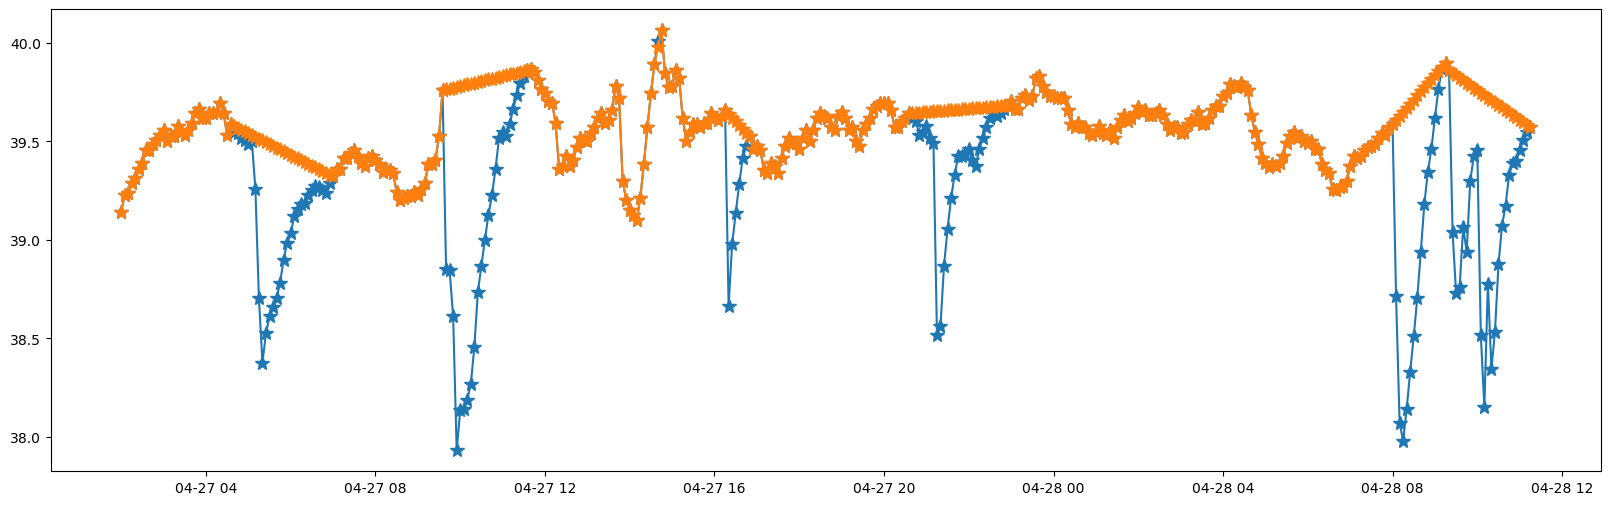

In [9]:
sheep_id = 'M0177'
diff_heat = heat_data[['DT', sheep_id]][0:1000]

condition = (diff_heat[sheep_id] > 30)
tmp_data = diff_heat[condition][['DT', sheep_id]]

plt.figure(figsize=(20, 6))  # 设置图形的大小
plt.plot(tmp_data['DT'][600:1000], tmp_data[sheep_id][600:1000], '-o', marker='*', markersize=10, label='Temperature')  # '-o'表示连线图，'*'表示星号标记


# Recalculate 'time_hour' based on the released data
tmp_data['seconds'] = tmp_data['DT'].dt.hour * 3600 + tmp_data['DT'].dt.minute * 60 + tmp_data['DT'].dt.second

tmp_data['time_hours'] = tmp_data['seconds'] / 3600
if tmp_data.shape[0] < 280:
    print(sheep_id, current_date, tmp_data.shape)

# # Filter abnormal values and using the interpolate method to makeup the data

tmp_data = remove_outliers_interpolate_drink(tmp_data, sheep_id)

plt.plot(tmp_data['DT'][600:1000], tmp_data[sheep_id][600:1000], '-o', marker='*', markersize=10, label='Temperature')  # '-o'表示连线图，'*'表示星号标记


# Data Preprocessing

In [10]:
import copy
sheep_data = copy.deepcopy(heat_data)

#Convert 'DT' columns to datetime
sheep_data['DT'] = pd.to_datetime(sheep_data['DT'])
sheep_data['date'] = sheep_data['DT'].dt.date
sheep_data['date'] = sheep_data['date'].astype('str')
sheep_data['hour'] = sheep_data['DT'].dt.hour
sheep_data['hour'] = sheep_data['hour'].astype('str')
sheep_data['DataTime'] = sheep_data['DT']
sheep_data.set_index('DataTime', inplace=True)
    
# Recalculate 'time_hour' based on the released data
sheep_data['time_hours'] = (sheep_data.index - sheep_data.index[0]).total_seconds() / 3600.0
sheep_data = sheep_data.reset_index()

sheep_data.head()

,DataTime,DT,row,M0177,M1215,M1221,M1241,M1275,M1278,date,hour,time_hours
0,2024-04-24 23:59:59.990,2024-04-24 23:59:59.990,36662,39.556083,39.815960,39.447140,39.873958,40.338244,39.815049,2024-04-24,23,0.000000
1,2024-04-25 00:04:59.990,2024-04-25 00:04:59.990,36663,39.610716,39.808166,39.493920,39.686911,40.353814,39.846257,2024-04-25,0,0.083333
2,2024-04-25 00:09:59.990,2024-04-25 00:09:59.990,36664,39.704372,39.800372,38.402370,39.772641,40.338244,39.846257,2024-04-25,0,0.166667
3,2024-04-25 00:14:59.990,2024-04-25 00:14:59.990,36665,39.759005,39.784784,38.745429,39.889545,40.182546,39.861860,2024-04-25,0,0.250000
4,2024-04-25 00:19:59.990,2024-04-25 00:19:59.990,36666,39.782419,39.800372,39.049504,39.905132,40.151407,39.916474,2024-04-25,0,0.333333


# Cosinor Analysis: extract the mesor, amplitude, and phase

In [11]:
# Define the cosinor model function
def cosinor_model(t, M, A, phi):
    T = 24  # period is 24 hours for 
    return M + A * np.cos(2 * np.pi * t / T + phi)

# Function to perform cosinor analysis
def perform_cosinor_analysis(temp_data, time_hours):
    try:
        # filter abnormal values and 
        
        # Initial guesses for the parameters
        M_guess = temp_data.mean()
        A_guess = (temp_data.max() - temp_data.min()) / 2
        phi_guess = 0

        # Fit the cosinor model
        params, _ = curve_fit(cosinor_model, time_hours, temp_data, p0=[M_guess, A_guess, phi_guess])
        M, A, phi = params

        # Compute R-squared
        residuals = temp_data - cosinor_model(time_hours, *params)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((temp_data - temp_data.mean())**2)
        r_squared = 1 - (ss_res / ss_tot)
        return M, abs(A), phi, r_squared
    except Exception as e:
        return np.nan, np.nan, np.nan, np.nan
    
    
# Function to extract the percentage rank data based on the data you want
def extract_pointed_temp_value(temp_data, percentage_split):
    temp_sorted = temp_data.sort_values(ascending=True)
    temp_sorted_inverse = temp_data.sort_values(ascending=False)
    
    indice = int(percentage_split * len(temp_data))
    
    return temp_sorted.iloc[indice], temp_sorted_inverse.iloc[indice]
    

In [12]:
# s = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# print(extract_pointed_temp_value(s, 0.45))

In [13]:
# import pandas as pd
 
# # 创建一个Pandas Series
# s = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
 
# # 对Series进行排序
# s_sorted = s.sort_values(ascending=True)
# s_sorted_inverse = s.sort_values(ascending=False)

 
# # 计算每个百分比位置的索引
# percentiles = [0.01, 0.10, 0.15]
# indices = [int(len(s_sorted) * p) for p in percentiles]
 
# # 获取每个百分比位置的值
# values = {f'{p*100}%': v for p, v in zip(percentiles, s_sorted.iloc[indices])}
# values_inverse = {f'{p*100}%': v for p, v in zip(percentiles, s_sorted_inverse.iloc[indices])}
 
# print(values)
# print(values_inverse)

### single sheep data test

In [14]:
# Select the first sheep ID from the dataset as an example for simplification
example_sheep_id = sheep_data.columns[5]

selected_sheep_data = sheep_data[(sheep_data[example_sheep_id] > 30) & (sheep_data['date'] == '2023-02-16')][['DT', example_sheep_id, 'time_hours']]
print(selected_sheep_data.shape)
selected_sheep_data = remove_outliers_interpolate_drink(selected_sheep_data, example_sheep_id)
# Perform Cosinor analysis for the example sheep
M, A, phi, r_squared = perform_cosinor_analysis(selected_sheep_data[example_sheep_id], selected_sheep_data['time_hours'])

# Output the results for the example sheep
M, A, phi, r_squared

(0, 3)


(nan, nan, nan, nan)

In [15]:
sheep_data.columns[0]

'DataTime'

## Extract the cosinor parameters for each sheep of each day

In [16]:
sheep_data_colums = list(sheep_data.columns)

# 【1】 extract sheep id
sheep_id_list = []
for sheep_id in sheep_data_colums:
#     if 'G' in sheep_id:
#         sheep_id_list.append(sheep_id)
#     elif 'Y' in sheep_id:
#         sheep_id_list.append(sheep_id)
#     elif 'P' in sheep_id:
#         sheep_id_list.append(sheep_id)
#     else:
#         print(sheep_id)
    if 'M' in sheep_id:
        sheep_id_list.append(sheep_id)

# 【2】 extract temperature record date
sheep_record_date_list = list(set(sheep_data['date']))
sheep_record_date_list.sort()
# sheep_record_date_list



In [17]:
sheep_record_date_list

['2024-04-24',
 '2024-04-25',
 '2024-04-26',
 '2024-04-27',
 '2024-04-28',
 '2024-04-29',
 '2024-04-30',
 '2024-05-01',
 '2024-05-02',
 '2024-05-03',
 '2024-05-04',
 '2024-05-05',
 '2024-05-06',
 '2024-05-07',
 '2024-05-08']

In [18]:
# 'percent_{}_min'.format(str(1))

In [19]:
def remove_outliers_interpolate(df, col_name, joint_thresh=0.1, win_thresh=0.8, win_size=12):
    # Identify points with a difference greater than 0.2 with its previous point
    df['diff'] = df[col_name].diff().abs()
    outliers_diff = df['diff'] > joint_thresh

    # Identify windows of 10 points where the temperature change is greater than 0.5 degrees
    # To avoid applying the condition to the NaN values that will be introduced by diff, we will fill them with 0
    rolling_max = df[col_name].rolling(window=win_size, min_periods=1).max()
    rolling_min = df[col_name].rolling(window=win_size, min_periods=1).min()
    outliers_rolling = (rolling_max - rolling_min) > win_thresh

    # Combine both outlier conditions
    outliers = outliers_diff | outliers_rolling

    # Mark the identified outliers as NaN
    df.loc[outliers, col_name] = np.nan

    # Interpolate the data where outliers were found
    df[col_name] = df[col_name].interpolate(method='linear')

    # Drop the auxiliary columns used for calculations
    df.drop(columns=['diff'], inplace=True)

    return df



In [20]:
# 【3】 extract the cosinor parameters for each sheep every day
cosinor_dict = {
    "group": [],
    "sheep_id": [],
    "record_date": [],
    "record_num":[],
    "M":[],
    "A": [],
    "phi": [],
    "r_squared": [],
    "percent_1_max": [],
    "percent_1_min": [],
    "percent_5_max": [],
    "percent_5_min": [],
    "percent_10_max": [],
    "percent_10_min": [],
    "percent_20_max": [],
    "percent_20_min": [],
    "percent_30_max": [],
    "percent_30_min": [],
    "percent_40_max": [],
    "percent_40_min": [],
    "percent_45_max": [],
    "percent_45_min": [],
}

percent_list = [1, 5, 10, 20, 30, 40, 45]

for sheep_id in sheep_id_list:
    for current_date in sheep_record_date_list:        
        condition = (sheep_data[sheep_id] > 30) & (sheep_data['date'] == current_date)
        tmp_data = sheep_data[condition][['DT', sheep_id]]
#         tmp_data.set_index('DT', inplace=True)
#         print(tmp_data.head())

        # Recalculate 'time_hour' based on the released data
        tmp_data['seconds'] = tmp_data['DT'].dt.hour * 3600 + tmp_data['DT'].dt.minute * 60 + tmp_data['DT'].dt.second

        tmp_data['time_hours'] = tmp_data['seconds'] / 3600
        if tmp_data.shape[0] < 280:
            continue
#         print(sheep_id, current_date, tmp_data.shape)

        # Filter abnormal values and using the interpolate method to makeup the data
        tmp_data['Datetime'] = tmp_data['DT']
        tmp_data = tmp_data.set_index('Datetime')
        
        tmp_data = remove_outliers_interpolate_drink(tmp_data, sheep_id)
#         tmp_data = remove_outliers_interpolate(tmp_data, sheep_id)
        # Perform Cosinor analysis for the example sheep
        M, A, phi, r_squared = perform_cosinor_analysis(tmp_data[sheep_id], tmp_data['time_hours'])
        
#         print(sheep_id, M, A, phi, r_squared)
        
        for percent in percent_list:
            min_val, max_val = extract_pointed_temp_value(tmp_data[sheep_id], percent / 100.0)
            
            min_key = 'percent_{}_min'.format(str(percent))
            max_key = 'percent_{}_max'.format(str(percent))
            cosinor_dict[min_key].append(min_val)
            cosinor_dict[max_key].append(max_val)
    
        
        cosinor_dict['group'].append(sheep_id[0])
        cosinor_dict['sheep_id'].append(sheep_id)
        cosinor_dict['record_date'].append(current_date)
        cosinor_dict['record_num'].append(tmp_data.shape[0])
        cosinor_dict['M'].append(M)
        cosinor_dict['A'].append(A)
        cosinor_dict['phi'].append(phi)
        cosinor_dict['r_squared'].append(r_squared)
        

cosinor_df = pd.DataFrame(cosinor_dict)
cosinor_df.to_csv('2024_cosinor_extraction_each_sheep_every_day_202405151543.csv', index=False)
cosinor_df_bk = cosinor_df.copy()
# cosinor_df_bk.head()
cosinor_df.head()   
cosinor_df = cosinor_df[cosinor_df['r_squared'] >= 0.5]

In [21]:
# tmp_cnt = 0
# for sheep_id in sheep_id_list:
# #     for current_date in sheep_record_date_list:        
#     condition = (sheep_data[sheep_id] > 30) & (sheep_data['date'] == '2023-02-14')
#     tmp_data = sheep_data[condition][['DT', sheep_id]]
# #     tmp_data.set_index('DT', inplace=True)
# #     print(tmp_data.head())

#     # Recalculate 'time_hour' based on the released data
#     tmp_data['seconds'] = tmp_data['DT'].dt.hour * 3600 + tmp_data['DT'].dt.minute * 60 + tmp_data['DT'].dt.second

#     tmp_data['time_hours'] = tmp_data['seconds'] / 3600
    
#     if tmp_data.shape[0] < 280:
#             print(sheep_id, tmp_data.shape[0])
#             tmp_cnt += 1
            
# print(tmp_cnt)

In [22]:
len(sheep_id_list)

6

['M0177', 'M1215', 'M1221', 'M1241', 'M1275']


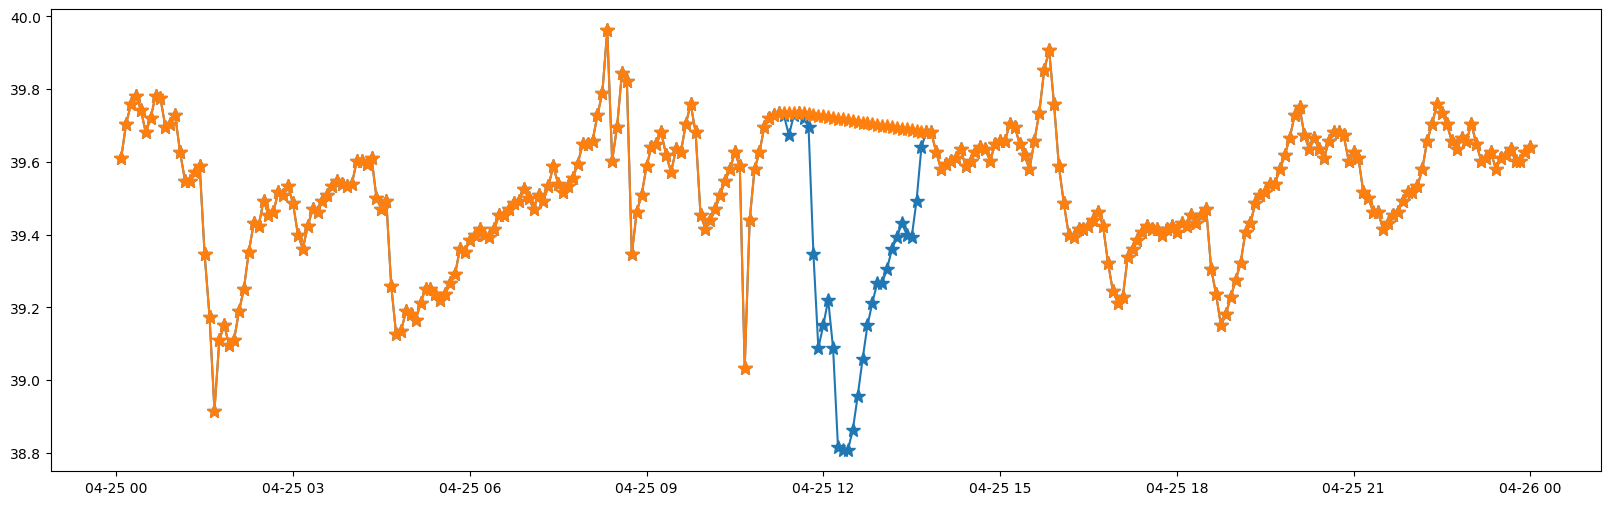

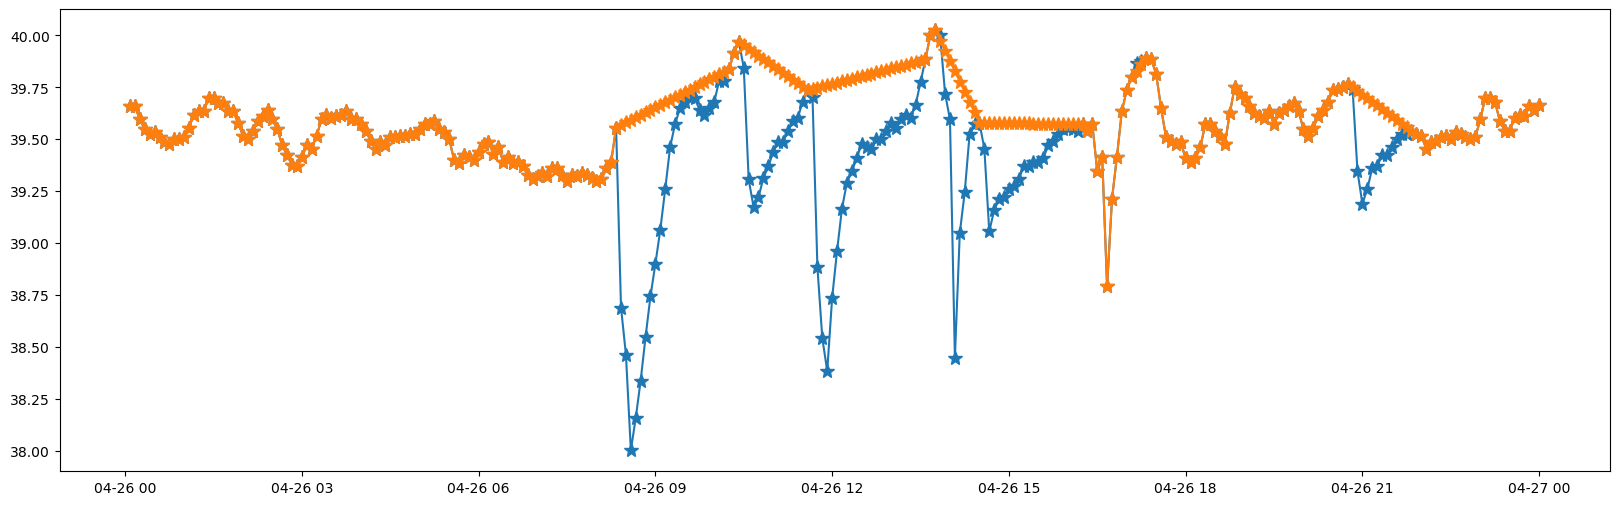

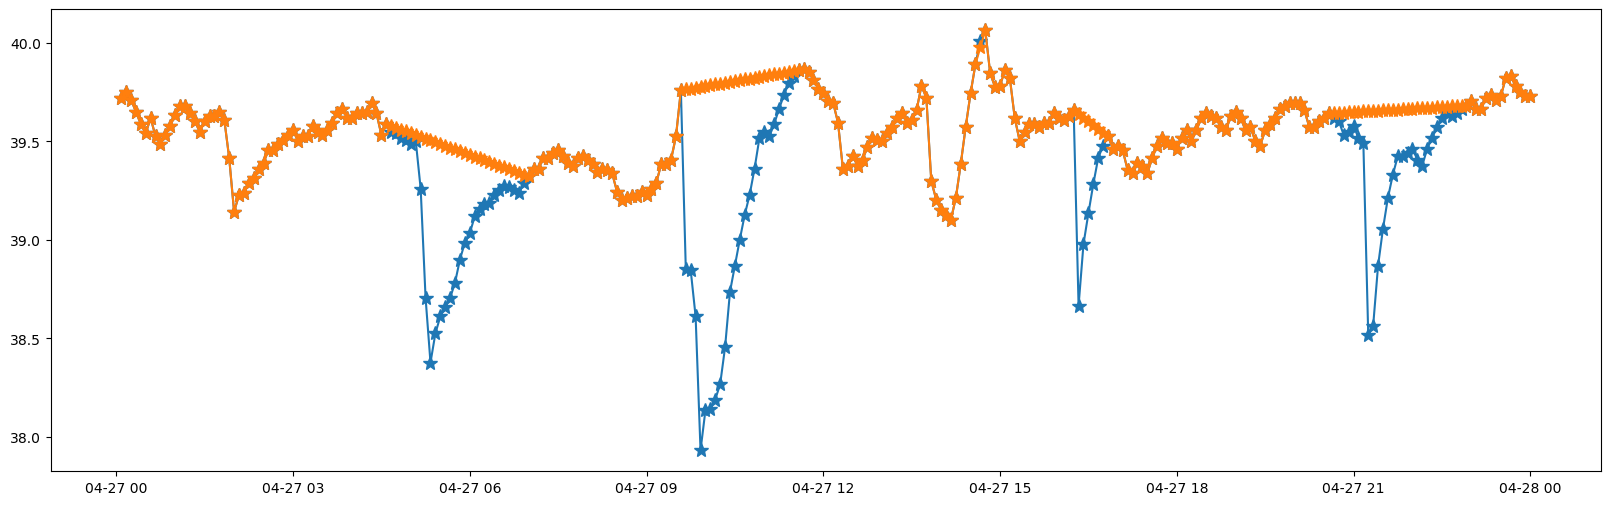

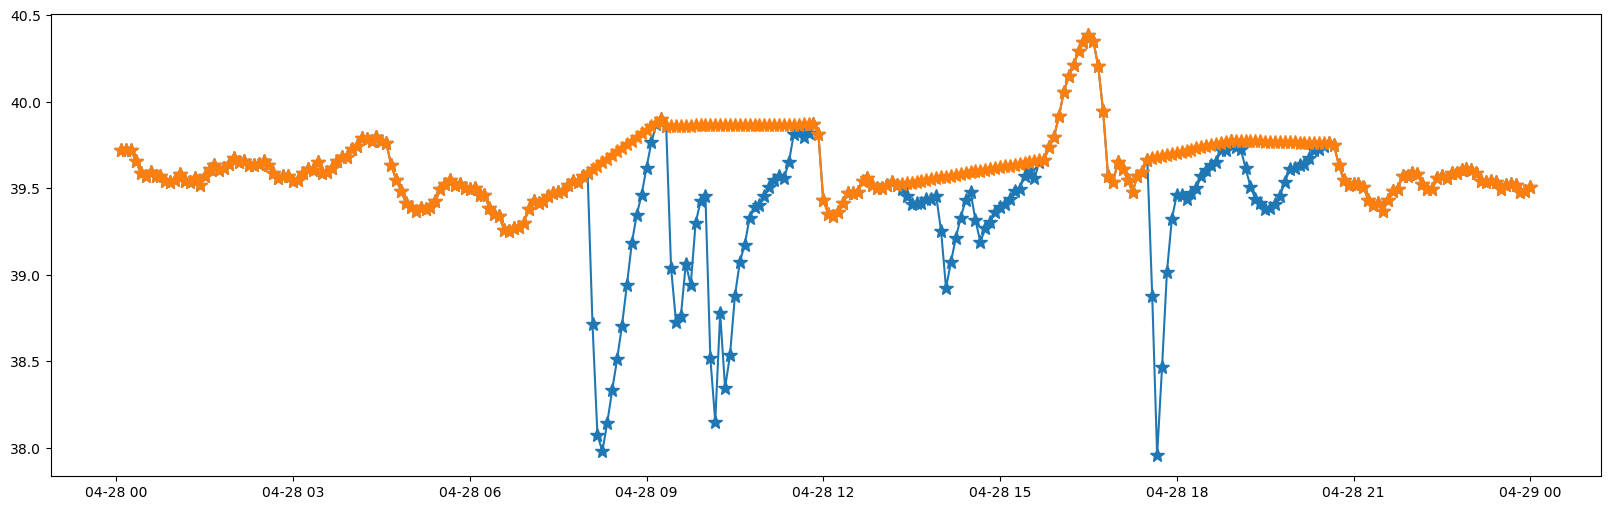

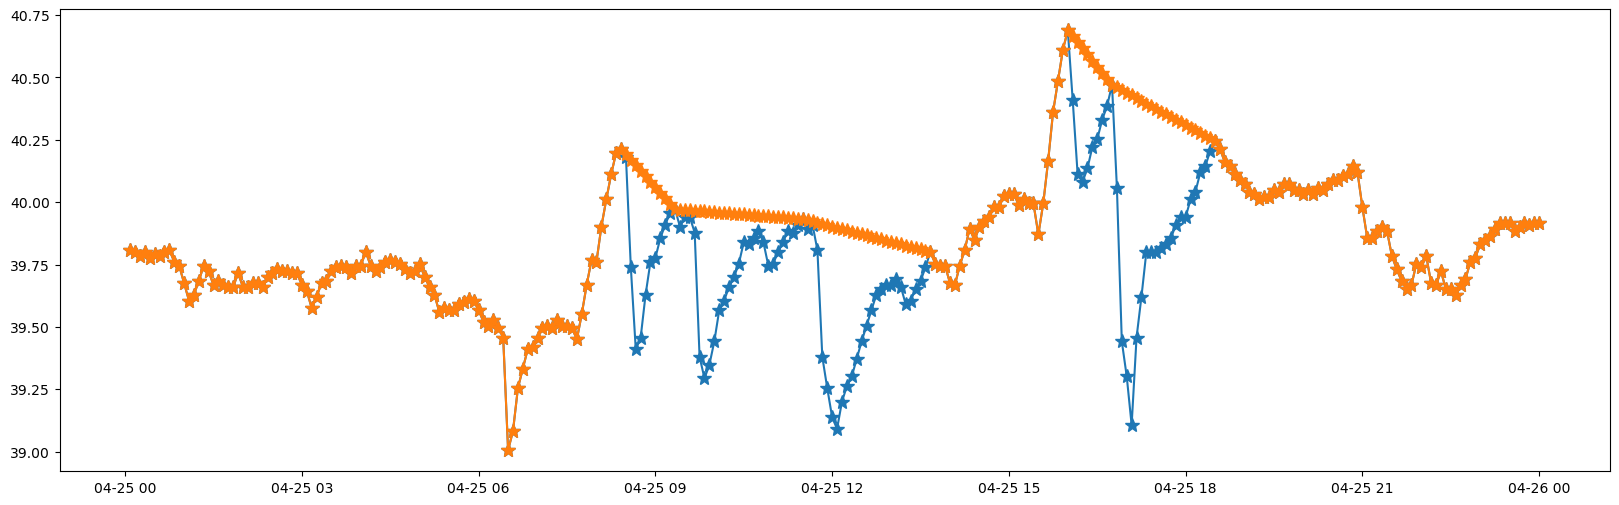

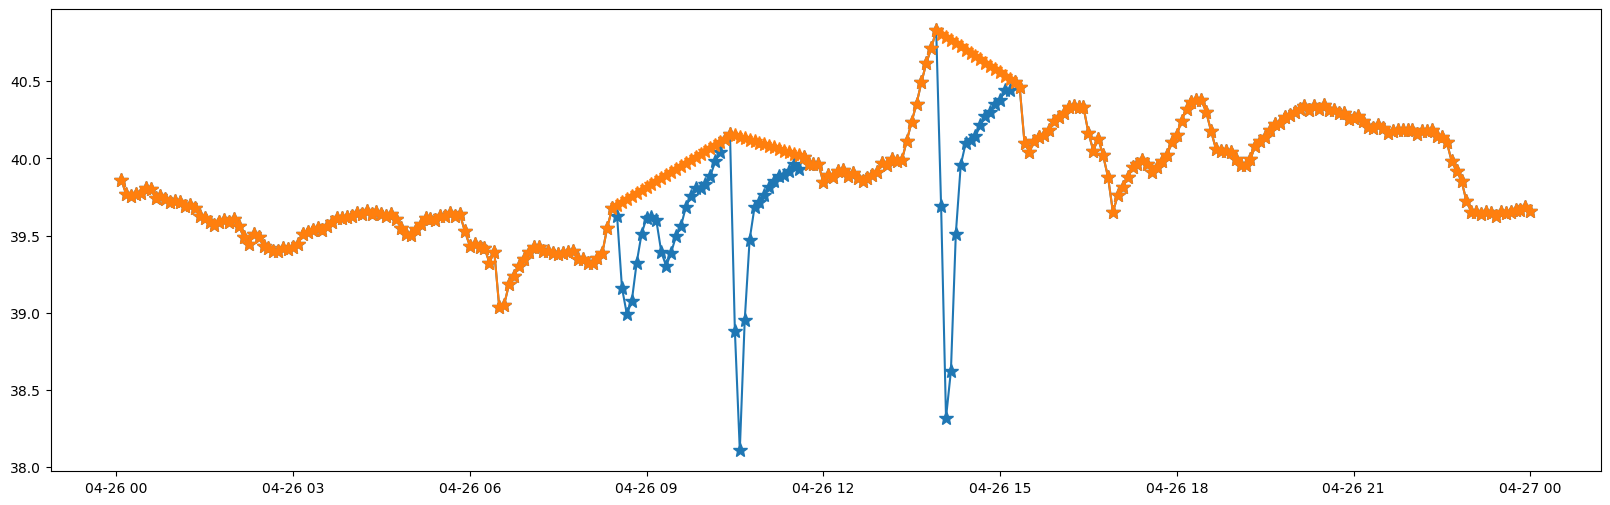

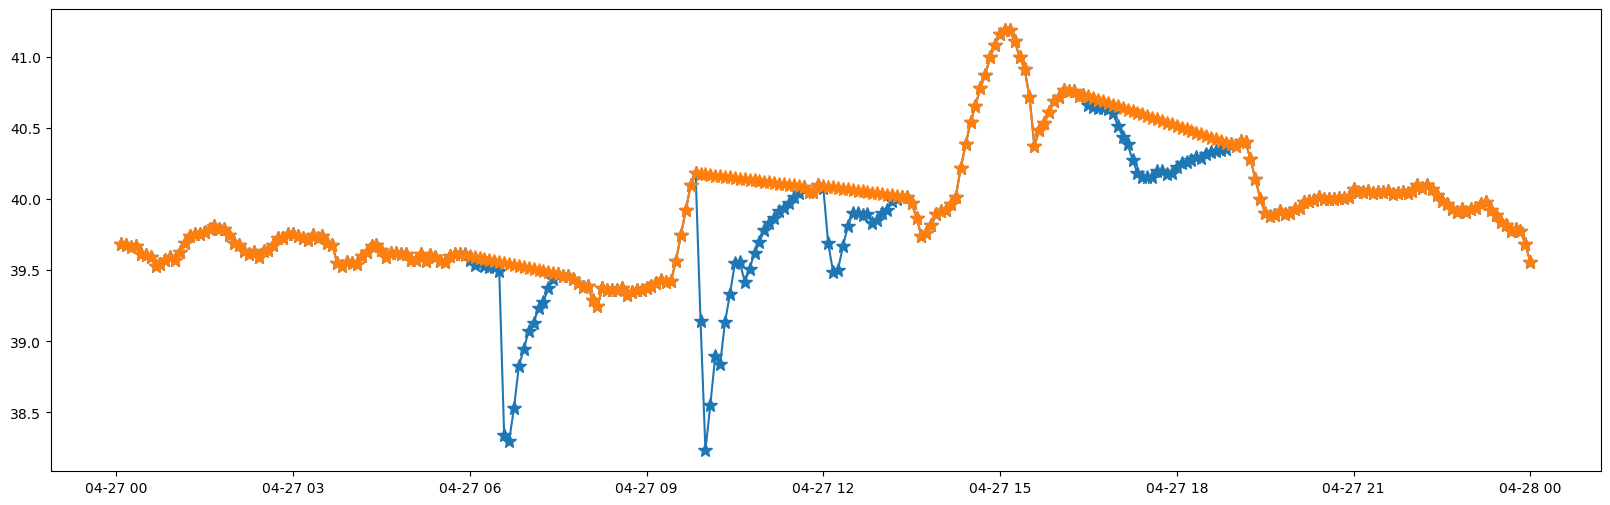

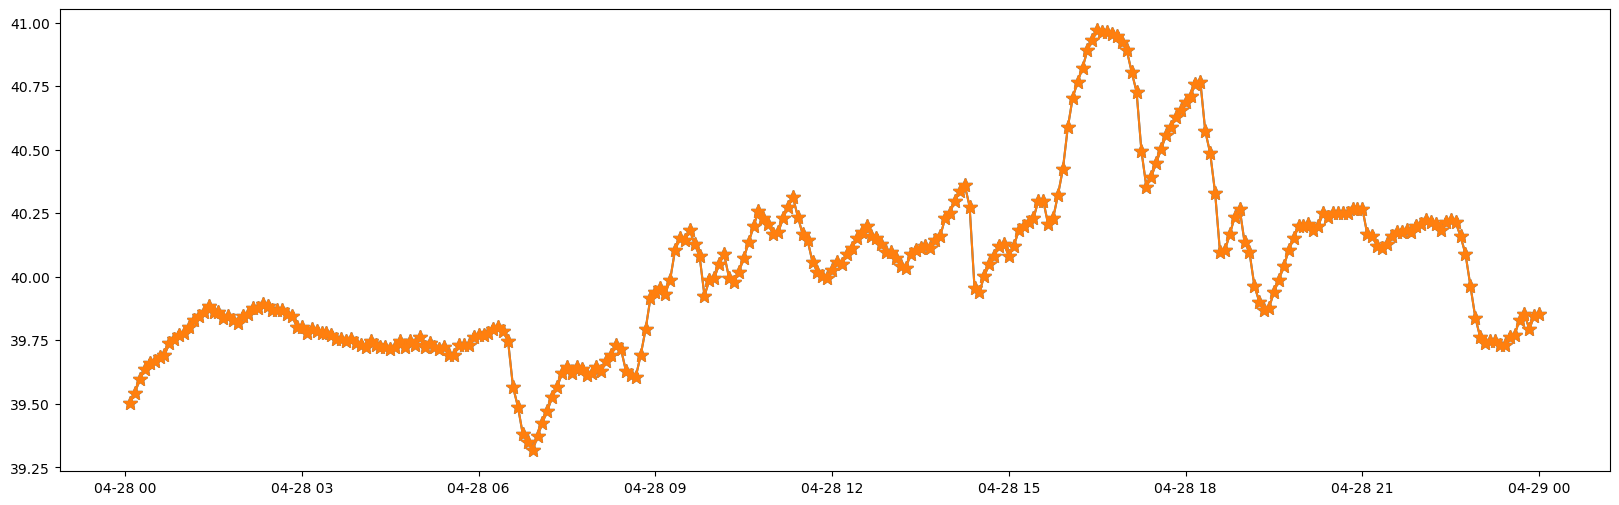

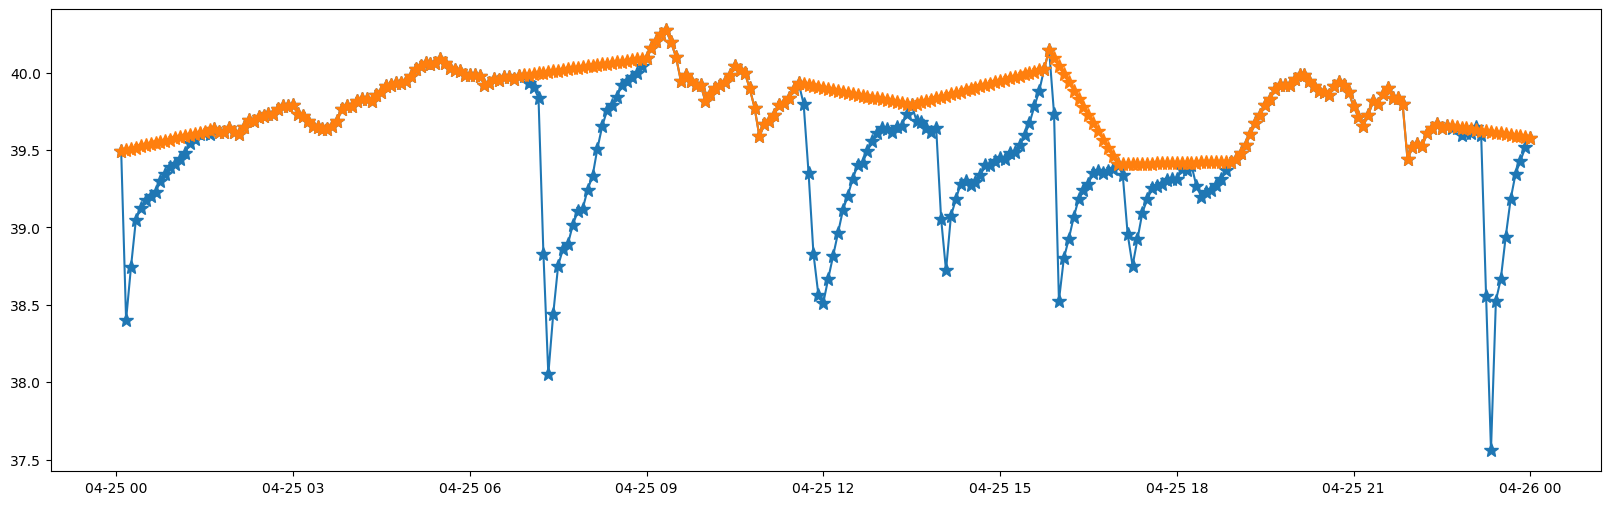

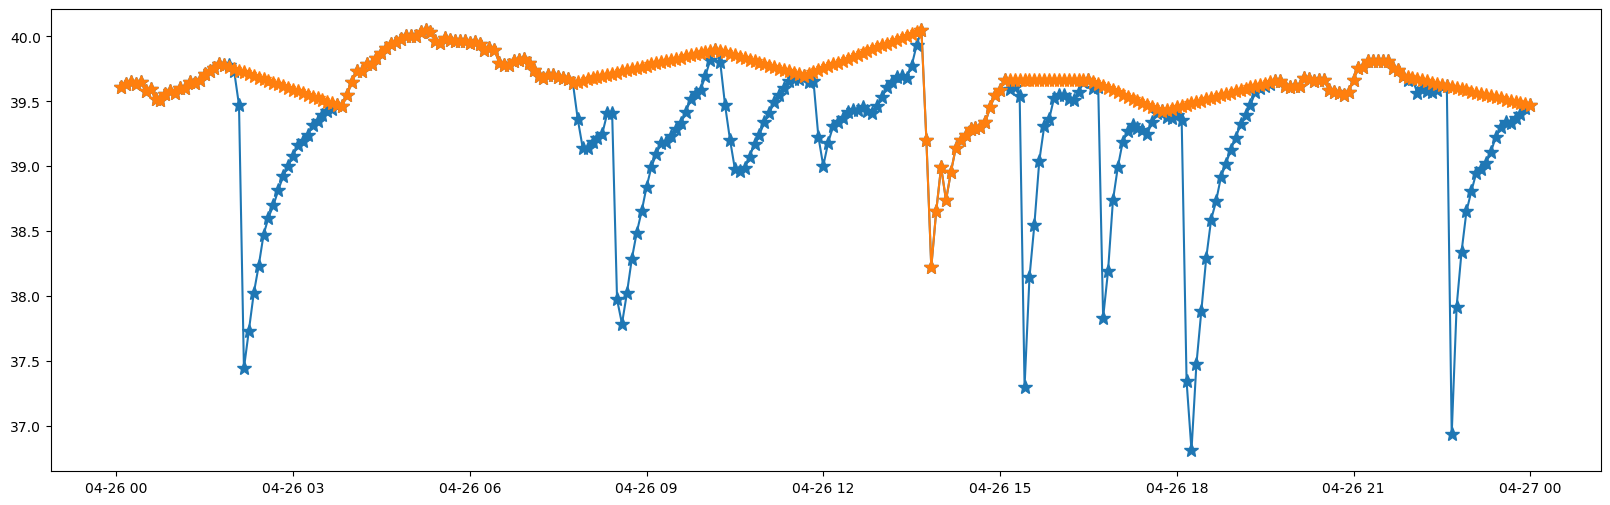

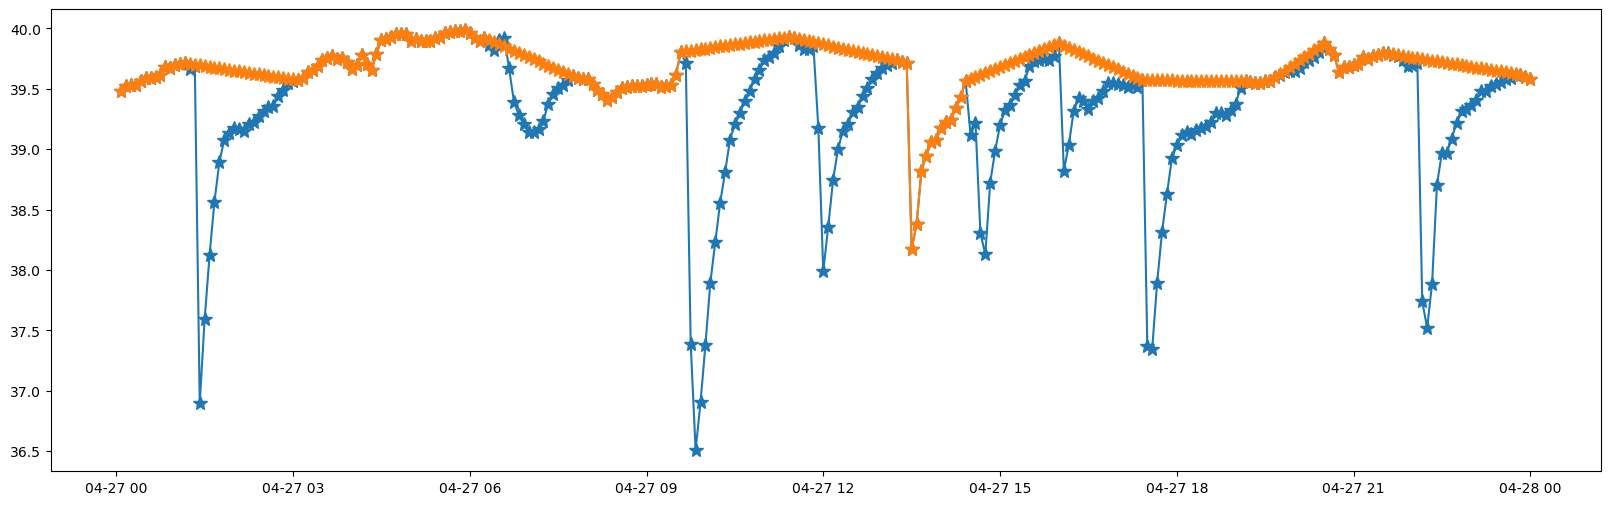

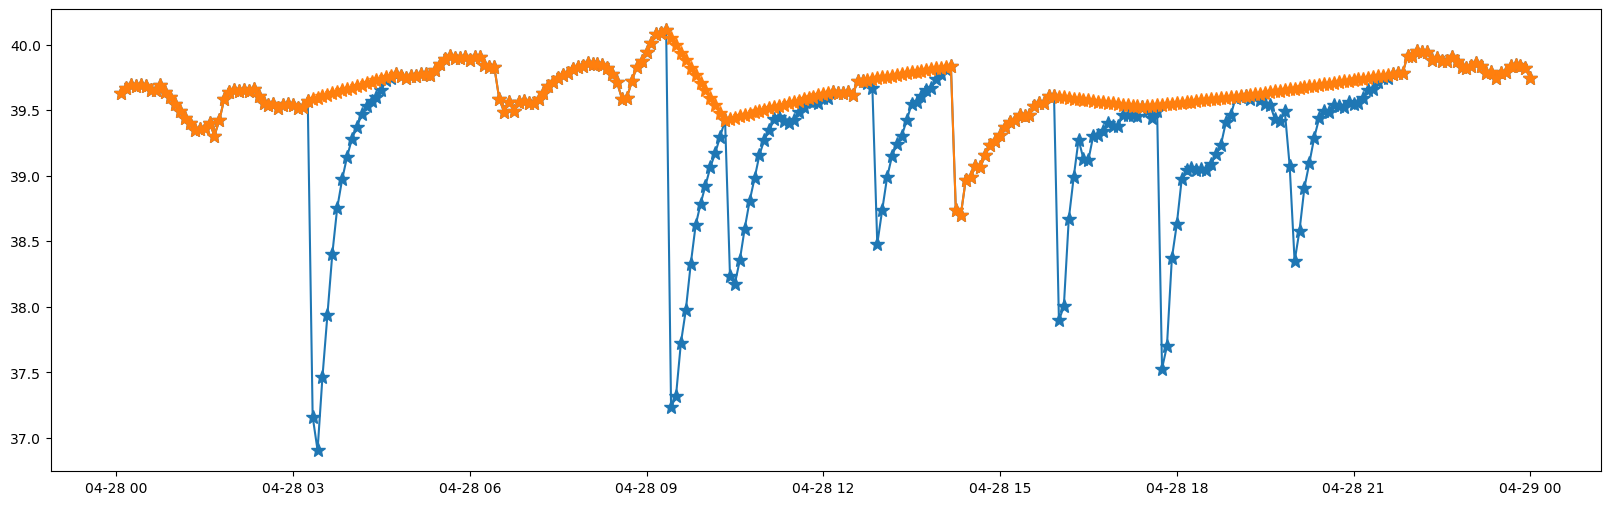

In [23]:
print(sheep_id_list[:5])
for sheep_id in sheep_id_list[:3]:
    for current_date in sheep_record_date_list[:5]:        
        condition = (sheep_data[sheep_id] > 30) & (sheep_data['date'] == current_date)
        tmp_data = sheep_data[condition][['DT', sheep_id]]
#         tmp_data.set_index('DT', inplace=True)
#         print(tmp_data.head())

        # Recalculate 'time_hour' based on the released data
        tmp_data['seconds'] = tmp_data['DT'].dt.hour * 3600 + tmp_data['DT'].dt.minute * 60 + tmp_data['DT'].dt.second

        tmp_data['time_hours'] = tmp_data['seconds'] / 3600
        if tmp_data.shape[0] < 280:
            continue
#         print(sheep_id, current_date, tmp_data.shape)

        # Filter abnormal values and using the interpolate method to makeup the data
        plt.figure(figsize=(20, 6))  # 设置图形的大小
        plt.plot(tmp_data['DT'][0:600], tmp_data[sheep_id][0:600], '-o', marker='*', markersize=10, label='Temperature')  # '-o'表示连线图，'*'表示星号标记
                
        tmp_data['DT'] = pd.to_datetime(tmp_data['DT'])
        tmp_data = remove_outliers_interpolate_drink(tmp_data, sheep_id)
#         tmp_data = remove_outliers_interpolate(tmp_data, sheep_id)
        tmp_data['Datetime'] = tmp_data['DT']
        tmp_data = tmp_data.set_index('Datetime')

        
        
        plt.plot(tmp_data['DT'][0:600], tmp_data[sheep_id][0:600], '-o', marker='*', markersize=10, label='Temperature')  # '-o'表示连线图，'*'表示星号标记



In [24]:
# cosinor_df = pd.read_csv('cosinor_extraction_each_sheep_every_day.csv')

In [25]:

# (39.618194385996375,
#  0.37555375518056805,
#  1.2582001559020697,
#  0.1960525664511671)

In [26]:
# # Select the first sheep ID from the dataset as an example for simplification
# example_sheep_id = sheep_data.columns[0]

# selected_sheep_data = sheep_data[sheep_data[example_sheep_id] > 30][[example_sheep_id, 'time_hours']]

# selected_sheep_data
# # Perform Cosinor analysis for the example sheep
# M, A, phi, r_squared = perform_cosinor_analysis(selected_sheep_data[example_sheep_id], selected_sheep_data['time_hours'])

# # Output the results for the example sheep
# M, A, phi, r_squared

In [27]:
cosinor_df.head()

,group,sheep_id,record_date,record_num,M,A,phi,r_squared,percent_1_max,percent_1_min,...,percent_10_max,percent_10_min,percent_20_max,percent_20_min,percent_30_max,percent_30_min,percent_40_max,percent_40_min,percent_45_max,percent_45_min
11,M,M1215,2024-04-25,288,39.893629,0.274857,-1.215148,0.507727,40.640389,39.254793,...,40.298444,39.597728,40.073161,39.675668,39.979633,39.738020,39.934368,39.800372,39.907389,39.836044
12,M,M1215,2024-04-26,288,39.906741,0.417770,-1.201533,0.665310,40.787284,39.184648,...,40.338156,39.426261,40.197865,39.589934,40.112131,39.652286,40.018603,39.769196,39.964045,39.862724
13,M,M1215,2024-04-27,288,39.967631,0.496428,-1.241179,0.701037,41.164318,39.324939,...,40.618739,39.508098,40.377126,39.589934,40.093000,39.667874,40.041527,39.776990,40.003015,39.893900
14,M,M1215,2024-04-28,288,40.025964,0.376285,-1.250989,0.656169,40.961674,39.371703,...,40.423890,39.667874,40.229041,39.738020,40.174483,39.792578,40.112131,39.870518,40.088749,39.956251
15,M,M1215,2024-04-29,288,40.027412,0.392468,-0.782689,0.631796,40.805795,39.317145,...,40.603151,39.636698,40.341014,39.745814,40.205659,39.800372,40.073161,39.847136,39.979633,39.886106


In [28]:
def phi_to_time(phi_smoothed):
    # Convert the smoothed phase shift (phi_smoothed) from radians to hours within the 24-hour period
    phi_smoothed_hours = ((phi_smoothed + np.pi) % (2 * np.pi)) * (24 / (2 * np.pi))
    phi_smoothed_time = (phi_smoothed_hours % 24)  # Ensure it's within 0 to 24 hours range

    # Convert phi_smoothed into a more interpretable format, e.g., "hours:minutes"
    phi_smoothed_hours_int = int(phi_smoothed_hours)
    phi_smoothed_minutes = int((phi_smoothed_hours - phi_smoothed_hours_int) * 60)
    phi_smoothed_time_formatted = f"{phi_smoothed_hours_int:02d}:{phi_smoothed_minutes:02d}"

    return phi_smoothed_time_formatted

In [29]:
phi_to_time(0.301383)

'13:09'

In [30]:
# cosinor_df[cosinor_df['sheep_id'] == sheep_id_list[0]]

# Cosinor resutls analysis

In [31]:
def visualization_cosinor_stat(cosinor_df):
    # Plot histograms for Mesor, Amplitude, and Phase for each group
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Mesor
    cosinor_df.boxplot(column='M', by='group', ax=axes[0])
    axes[0].set_title('Mesor (Average Body Temperature)')
    axes[0].set_ylabel('Temperature (°C)')

    # Amplitude
    cosinor_df.boxplot(column='A', by='group', ax=axes[1])
    axes[1].set_title('Amplitude (Temperature Variation)')
    axes[1].set_ylabel('Amplitude (°C)')

    # Phase
    cosinor_df.boxplot(column='phi', by='group', ax=axes[2])
    axes[2].set_title('Phase (Timing of Peak Temperature)')
    axes[2].set_ylabel('Phase (radians)')

    # Adjust layout and display plots
    plt.suptitle('Comparison of Cosinor Parameters Across Groups')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [32]:
# First, let's provide summary statistics (mean, variance, etc.) for each parameter (Mesor, Amplitude, Phase) by group.
summary_stats = cosinor_df.groupby('group')[['M', 'A', 'phi', 'r_squared']].agg(['mean', 'var', 'std', 'min', 'max'])

# Display the summary statistics for each parameter by group
summary_stats

M                                                   A  \
            mean       var       std        min        max      mean   
group                                                                  
M      39.939108  0.054333  0.233095  39.419789  40.277225  0.362671   

                                                    phi                      \
            var       std       min       max      mean       var       std   
group                                                                         
M      0.008463  0.091993  0.219117  0.554942 -0.334987  1.532224  1.237831   

                          r_squared                                        
            min       max      mean      var       std      min       max  
group                                                                      
M     -1.359911  1.781771  0.629004  0.00734  0.085674  0.50624  0.783085

In [33]:
len(set(cosinor_df['sheep_id']))

4

# Visualize the resutls

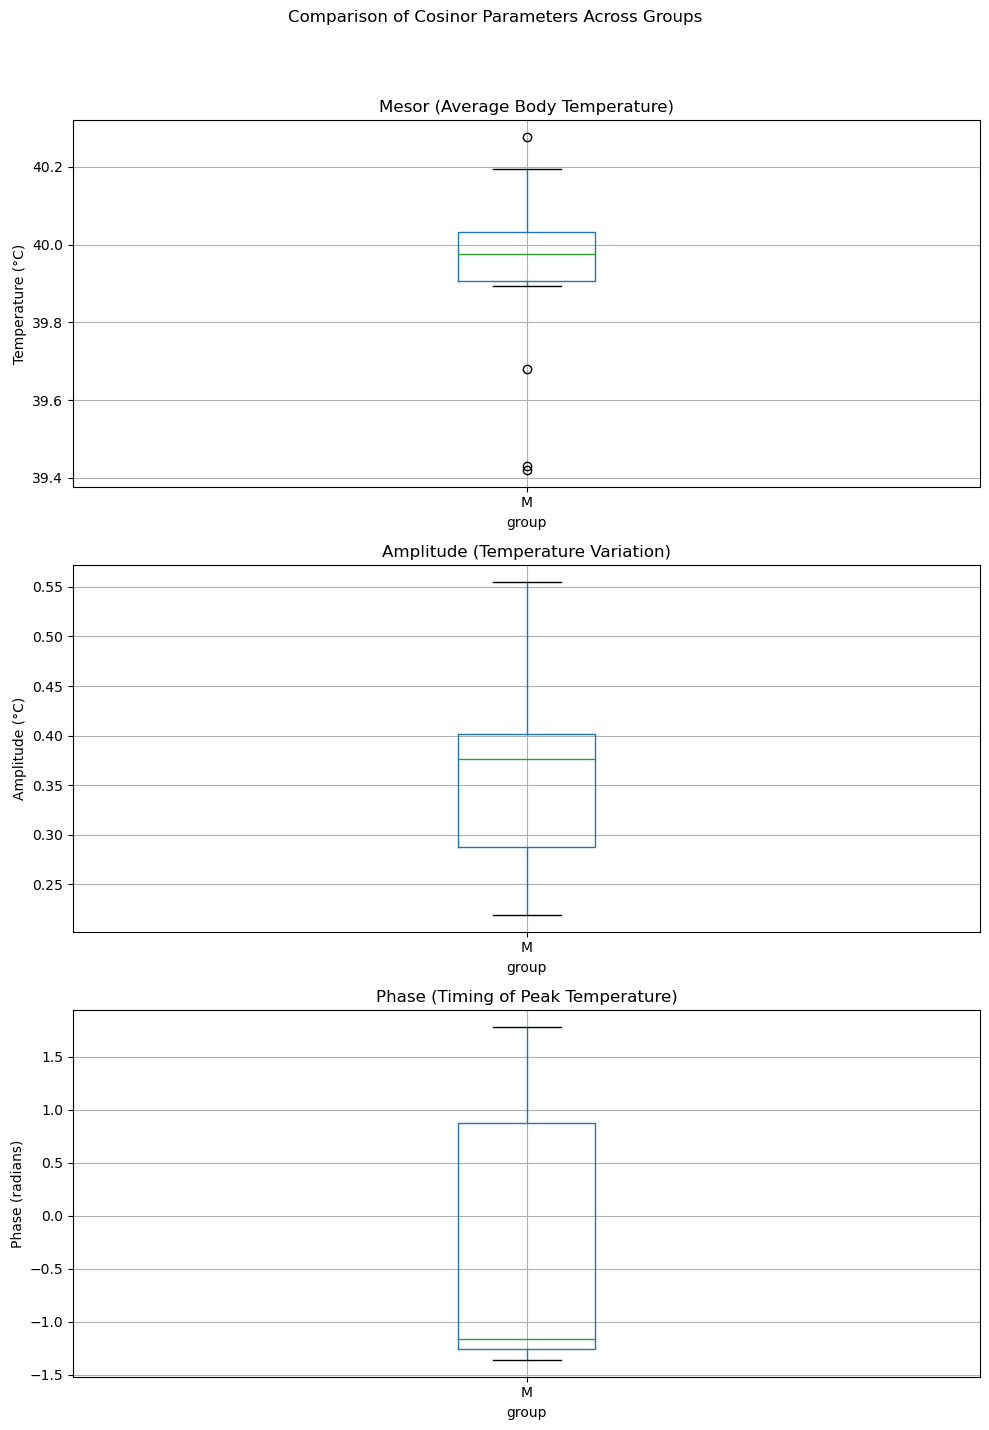

In [34]:
visualization_cosinor_stat(cosinor_df)

In [35]:
cosinor_df.groupby('group', as_index=False)['sheep_id'].count()

,group,sheep_id
0,M,17


In [36]:
# cosinor_df_bk.groupby('group', as_index=False)['sheep_id'].count()

In [37]:
cosinor_df[cosinor_df['record_date'] == '2022-02-19'].groupby('group', as_index=False)['sheep_id'].count()

,group,sheep_id


In [38]:
cosinor_df[cosinor_df['record_date'] == '2022-02-19'].sort_values(by='r_squared')

,group,sheep_id,record_date,record_num,M,A,phi,r_squared,percent_1_max,percent_1_min,...,percent_10_max,percent_10_min,percent_20_max,percent_20_min,percent_30_max,percent_30_min,percent_40_max,percent_40_min,percent_45_max,percent_45_min


In [39]:
import matplotlib.pyplot as plt

green_119_02_19 = sheep_data[sheep_data['date'].isin(['2022-02-19', '2022-02-20', '2022-02-21'])]['Green96']

plt.figure(figsize=(20, 6))  # 设置图形的大小
plt.plot( green_119_02_19, '-o', marker='*', markersize=10, label='Temperature')  # '-o'表示连线图，'*'表示星号标记


# sheep_data.head()

KeyError: 'Green96'

In [ ]:
cosinor_df[cosinor_df['record_date'] == '2022-02-28'].groupby('group', as_index=False)['sheep_id'].count()

In [ ]:
cosinor_df[cosinor_df['record_date'] == '2022-02-28']

## Hottest day analysis
- Feb 19
- Feb 28

In [ ]:
feb_19_df = cosinor_df[cosinor_df['record_date'] == '2022-02-19']
feb_28_df = cosinor_df[cosinor_df['record_date'] == '2022-02-28']

# First, let's provide summary statistics (mean, variance, etc.) for each parameter (Mesor, Amplitude, Phase) by group.
feb_19_summary_stats = feb_19_df.groupby('group')[['M', 'A', 'phi', 'r_squared']].agg(['mean', 'var', 'std', 'min', 'max'])
feb_28_summary_stats = feb_28_df.groupby('group')[['M', 'A', 'phi', 'r_squared']].agg(['mean', 'var', 'std', 'min', 'max'])

# Display the summary statistics for each parameter by group
feb_19_summary_stats

In [ ]:
visualization_cosinor_stat(feb_19_df)

In [ ]:
feb_28_summary_stats

In [ ]:
visualization_cosinor_stat(feb_28_df)

# Load Pregnant Data

In [ ]:
master_file_df = pd.read_excel('Heat Stress Masterfile June 2022.xlsx' , sheet_name='Ewe.ram data')
master_file_df.head()

In [ ]:
preg_data = master_file_df[['VID','Preg scan']]
preg_data['VID'] = preg_data['VID'].astype('str').map(lambda x: x.replace(' ', ''))
cosinor_preg_df = pd.merge(cosinor_df, preg_data, left_on='sheep_id', right_on='VID')

In [ ]:
feb_28_df = cosinor_preg_df[cosinor_preg_df['record_date'] == '2022-02-28']
# feb_28_df.groupby('sheep_id') 


In [ ]:
feb_28_df.groupby('group', as_index=False)['sheep_id'].count()

In [ ]:
feb_28_df.groupby('group', as_index=False)['Preg scan'].mean()

In [ ]:
feb_19_df = cosinor_preg_df[cosinor_preg_df['record_date'] == '2022-02-19']

In [ ]:
feb_19_df.groupby('group', as_index=False)['sheep_id'].count()

In [ ]:
feb_19_df.groupby('group', as_index=False)['Preg scan'].mean()

In [ ]:
feb_19_df.sort_values(by='M', ascending=False).head(50)['Preg scan'].sum()

In [ ]:
feb_19_df.sort_values(by='M', ascending=True).head(50)['Preg scan'].sum()